In [1]:
# conda install keras

In [2]:
# pip install np_utils

In [3]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from tensorflow.keras.preprocessing import sequence
# from tensorflow.keras.utils import np_utils
from tensorflow.python.keras.utils.np_utils import to_categorical
import tensorflow.python.keras.utils.np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding
from tensorflow.keras.layers import LSTM
# from tensorflow.sklearn import preprocessing
# from tensorflow.sklearn.metrics import (precision_score, recall_score,
#                              f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
np.random.seed(0)
from tensorflow.keras.optimizers import RMSprop
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


### word2vec

In [4]:
from __future__ import print_function
from collections import OrderedDict

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt

import os
import sys
import codecs
import re
import numpy as np

parameters = OrderedDict()
parameters['word_dim'] = 300

In [5]:
crowdflower = pd.read_csv('/kaggle/input/data016/text_emotion.csv')
crowdflower= crowdflower[['sentiment', 'content']]
crowdflower.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [6]:
## encode sentiment column to onehot
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(crowdflower['sentiment'].to_numpy().reshape(-1, 1))
onehot_sentiment = enc.transform(crowdflower['sentiment'].to_numpy().reshape(-1, 1)).toarray()
# onehot_sentiment = onehot_sentiment.reshape((40000, 1, 13))
crowdflower.insert(1, "onehot_sentiment", list(onehot_sentiment))
crowdflower

,sentiment,onehot_sentiment,content
0,empty,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",@tiffanylue i know i was listenin to bad habi...
1,sadness,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Layin n bed with a headache ughhhh...waitin o...
2,sadness,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Funeral ceremony...gloomy friday...
3,enthusiasm,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",wants to hang out with friends SOON!
4,neutral,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",@dannycastillo We want to trade with someone w...
...,...,...,...
39995,neutral,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",@JohnLloydTaylor
39996,love,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",Happy Mothers Day All my love
39997,love,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",Happy Mother's Day to all the mommies out ther...
39998,happiness,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


### encode word

In [7]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    (item:count) pairs
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    
    return:
    dico: dictionary of (word:frequency) pairs
    word_to_id: dictionary of (word, id)
    id_to_word: dictionary of (id, word)
    """
    words = [[x.lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

In [8]:
## tokenising sentences
raw_content = crowdflower['content'].to_numpy()

processed_docs = []
for doc in raw_content:
    tokens = word_tokenize(doc)
#        filtered = [word for word in tokens if word not in stop_words]
#        stemmed = [stemmer.stem(word) for word in filtered]
    processed_docs.append(tokens)

In [9]:
dico_words,word_to_id,id_to_word = word_mapping(processed_docs, True)

Found 52746 unique words (654846 in total)


In [10]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [11]:
def prepare_dataset(sentences, word_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        data.append({
            'str_words': str_words, #list of all words in the sentence
            'words': words, #list of word index for all words in the sentence
        })
    return data

data = prepare_dataset(
    processed_docs, word_to_id, True
)

print("{} sentences".format(len(data)))

40000 sentences


In [12]:
all_word_embeds = {}
for i, line in enumerate(codecs.open('/kaggle/input/data21/data/glove.6B.300d.txt', 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


In [13]:
len(word_embeds)

52746

In [14]:
# data

In [15]:
word_indices = [i['words'] for i in data]
padded_indices = []
for sent in word_indices:
    padding_size = 110 - len(sent) 
    padded = sent + [0 for i in range(padding_size)]
    padded_indices.append(padded)

In [16]:
# word_to_id

In [17]:
crowdflower.insert(1, "padded_indices", list(padded_indices))
crowdflower

,sentiment,padded_indices,onehot_sentiment,content
0,empty,"[4, 48864, 1, 67, 1, 36, 3311, 5, 138, 4779, 8...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",@tiffanylue i know i was listenin to bad habi...
1,sadness,"[12504, 316, 162, 33, 8, 439, 3667, 13, 2272, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Layin n bed with a headache ughhhh...waitin o...
2,sadness,"[2713, 4125, 13, 1714, 246, 13, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Funeral ceremony...gloomy friday...
3,enthusiasm,"[441, 5, 700, 43, 33, 227, 186, 2, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",wants to hang out with friends SOON!
4,neutral,"[4, 25690, 60, 94, 5, 3407, 33, 264, 184, 116,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",@dannycastillo We want to trade with someone w...
...,...,...,...,...
39995,neutral,"[4, 6649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",@JohnLloydTaylor
39996,love,"[61, 157, 32, 40, 9, 56, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",Happy Mothers Day All my love
39997,love,"[61, 141, 18, 32, 5, 40, 6, 1576, 43, 71, 7, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",Happy Mother's Day to all the mommies out ther...
39998,happiness,"[4, 8652, 2806, 388, 2, 2, 2, 262, 24, 2, 2, 6...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [18]:
# padded_indices

In [19]:
from sklearn.model_selection import train_test_split
X = crowdflower['padded_indices'].to_numpy()
y = crowdflower['onehot_sentiment'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# X_train=np.array([np.array(xi, dtype='int64') for xi in X_train])
# X_test=np.array([np.array(xi, dtype='int64') for xi in X_test])
# y_train=np.array([np.array(xi, dtype='int64') for xi in y_train])
# y_test=np.array([np.array(xi, dtype='int64') for xi in y_test])
X_train=np.array([np.array(xi) for xi in X_train])
X_test=np.array([np.array(xi) for xi in X_test])
y_train=np.array([np.array(xi) for xi in y_train])
y_test=np.array([np.array(xi) for xi in y_test])
print("X train: ", len(X_train))
print("y train: ", len(y_train))
print("y test: ", len(y_test))

X train:  28000
y train:  28000
y test:  12000


In [20]:
X_train.dtype

dtype('int64')

### Zhou model

In [21]:
import tensorflow as tf

class ZhouBLSTMCNNModel:

    def __init__(self,
        embedding,
        em_drop_rate = 0.5,
        lstm_units   = 300,
        lstm_drop_rate = 0.2,
        conv_size    = (3, 3),
        conv_filters = 100,
        pool_size    = (2, 2),
        pool_drop_rate = 0.4):
        '''Constructor.
        # Parameters:
        embedding: Numpy array representing the embedding.
        em_drop_rate: Drop rate after the embedding layer.
        lstm_units: Size of the internal states of the LSTM cells.
        lstm_drop_rate: Drop rate after the lstm layer.
        conv_size: Size of the convolutions.
        conv_filters: Number of convolutions filters.
        pool_size: Size for the max pooling layer.
        pool_drop_rate: Drop rate of the max pooling layer.
        '''
        self._embedding      = embedding
        self._em_drop_rate   = em_drop_rate
        self._lstm_units     = lstm_units
        self._lstm_drop_rate = lstm_drop_rate
        self._conv_size      = conv_size
        self._conv_filters   = conv_filters
        self._pool_size      = pool_size
        self._pool_drop_rate = pool_drop_rate

    def __call__(self, input):
        self._embedding_tf = self._create_embedding_layer(
            self._em_drop_rate, self._embedding, input)

        self._sequences_tf = self._create_blstm_layer(
            self._lstm_units,
            self._lstm_drop_rate,
            self._embedding_tf)

        self._convolution_tf = self._create_convolutional_layer(
            self._conv_size,
            self._conv_filters,
            self._sequences_tf)
        
        self._pooling_tf = self._create_maxpooling_layer(
            self._pool_size,
            self._pool_drop_rate,
            self._convolution_tf)

        self._flatten_tf = self._create_flatten_layer(self._pooling_tf)

        return self._flatten_tf

    def summary(self):
        print("embedding: " + str(self._embedding_tf.shape))
        print("lstm: " + str(self._sequences_tf.shape))
        print("conv: " + str(self._convolution_tf.shape))
        print("pooling: " + str(self._pooling_tf.shape))
        print("flatten: " + str(self._flatten_tf.shape))

    # this function converts each word from input_x into dense vector of dimension 300 (dimension depending on word2vec)
    # embedding  = word_vector
    def _create_embedding_layer(self, em_drop_rate, embedding, input_x):
        embedding = tf.Variable(initial_value=embedding)

        embedded_chars = tf.nn.embedding_lookup(  # lookup word_vector(embedding) by index (input_x)
            embedding, tf.cast(input_x, 'int32'))

        return tf.nn.dropout(embedded_chars, rate=em_drop_rate)

    # bidirectional lstm layer
    # 
    def _create_blstm_layer(self, lstm_units, lstm_drop_rate, embedding):
        lstm_cell = tf.compat.v1.nn.rnn_cell.LSTMCell(lstm_units)
        sequence = tf.unstack(embedding, axis=1) #embedded input words
        
        # hs, _, _ are outputs, output_state_fw, output_state_bw respectively
        hs, _, _ = tf.compat.v1.nn.static_bidirectional_rnn(lstm_cell, lstm_cell, #forward and backward direction
            sequence, #input
            dtype=tf.float32)
        
        hs = tf.stack(
            values=hs,
            axis=1)
        ss = tf.math.reduce_sum(
            tf.reshape(hs, shape=[-1, hs.shape[1], 2, lstm_units]),
            axis=2
        )

        return tf.nn.dropout(ss, rate=lstm_drop_rate)

    def _create_convolutional_layer(self,
        conv_size, num_filters, tensor):
        
        print(str(tensor.shape))

        filter_heigth = conv_size[0]
        filter_width  = conv_size[1]

        filter_shape = [filter_heigth, filter_width,
            1, num_filters]

        W = tf.Variable(
            initial_value=tf.random.truncated_normal(
                shape=filter_shape,
                stddev=0.1))
        b = tf.Variable(
            initial_value=tf.random.truncated_normal(
                shape=[num_filters]))

        tensor_expanded = tf.expand_dims(tensor, -1)
        conv = tf.nn.conv2d(
            input=tensor_expanded,
            filters=W, #####filter to filters, idk if it changed stuff
            strides=[1,1,1,1],
            padding='VALID')

        bias = tf.nn.bias_add(conv, b)
        c = tf.nn.relu(bias)

        return c

    def _create_maxpooling_layer(self, size, pool_drop_rate, conv):
        pooled = tf.nn.max_pool3d(
            input=tf.expand_dims(conv, -1),
            ksize=[1, size[0], size[1], conv.shape[3], 1],
            strides=[1, size[0], size[1], conv.shape[3], 1],
            padding='VALID')
        
        return tf.nn.dropout(pooled, rate=pool_drop_rate)

    def _create_flatten_layer(self, tensor):
        return tf.reshape(tensor, [-1, tensor.shape[1] * tensor.shape[2]])


if __name__ == '__main__':
    embedding_size  = 300
    num_words       = 1000
    sentence_length = 10

    embedding = [
        [float(i) for i in range(embedding_size)] for _ in range(num_words)
    ]
    data = [
        [i     for i in range(sentence_length)],
        [i + 1 for i in range(sentence_length)]
    ]

    model = ZhouBLSTMCNNModel(embedding)
    model(data)
    model.summary()

2021-11-12 20:07:54.697184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:07:54.814832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:07:54.815572: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:07:54.816721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(2, 10, 300)


2021-11-12 20:07:58.825368: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


embedding: (2, 10, 300)
lstm: (2, 10, 300)
conv: (2, 8, 298, 100)
pooling: (2, 4, 149, 1, 1)
flatten: (2, 596)


In [22]:
import tensorflow as tf
from numba import jit, cuda

class Classifier:

    def __init__(self, model, input_length, output_length):
        '''Constructor.
        # Parameters:
        input_length: sentence length (max number of words in sentence)
        output_length: number of classes of sentiment
        '''
        self.model = model
        self.input_length = input_length
        self.output_length = output_length

    def compile(self, batch_size=32):
        tf.compat.v1.disable_eager_execution()
        self._ds_x = tf.compat.v1.placeholder(tf.float32, [None, self.input_length])
        self._ds_y = tf.compat.v1.placeholder(tf.float32, [None, self.output_length])

        ds = tf.compat.v1.data.Dataset.from_tensor_slices((self._ds_x, self._ds_y))
        ds = ds.batch(batch_size)

        self._ds_it = ds.make_initializable_iterator()
        self._input, self._labels = self._ds_it.get_next()

        self._features = self.model(self._input)
        self._output = _create_dense_layer(self._features, self.output_length)

        self._create_acc_computations()
        self._create_backpropagation()

        self._session = tf.compat.v1.Session()
        self._session.run(tf.compat.v1.global_variables_initializer())
        self._session.run(tf.compat.v1.local_variables_initializer())

    def _create_acc_computations(self):
        self._predictions = tf.argmax(self._output, 1)
        labels = tf.argmax(self._labels, 1)
        self._accuracy = tf.reduce_mean(
            tf.cast(tf.equal(self._predictions, labels), 'float32'))

    def _create_backpropagation(self):
        losses = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(
            logits=self._output,
            labels=self._labels)
        self._loss = tf.reduce_mean(losses)

        optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        grads_and_vars = optimizer.compute_gradients(self._loss)

        self._train_op = optimizer.apply_gradients(
            grads_and_vars, global_step=global_step)

    def summary(self):
        print('input:', self._input.shape)
        self.model.summary()
        print('output:', self._output.shape)

#     @jit(target ="cuda")  
    def train(self, X_train, y_train, X_eval, y_eval, epochs=10):
        import time
        loss_ls, acc_ls, val_loss_ls, val_acc_ls = [],[],[],[]

        for e in range(epochs):
            start_time = time.time()
            loss, acc = self._train(X_train, y_train)
            loss_ls.append(loss)
            acc_ls.append(acc)
            duration = time.time() - start_time

            val_loss, val_acc = self._eval(X_eval, y_eval)
            val_loss_ls.append(val_loss)
            val_acc_ls.append(val_acc)

            output = 'Epoch: {}, loss = {:.4f}, acc = {:.4f}, val_loss = {:.4f}, val_acc = {:.4f}, Time = {:.2f}s'
            print(output.format(e + 1, loss, acc, val_loss, val_acc, duration))
        return loss_ls, acc_ls, val_loss_ls, val_acc_ls
        # endfor

#     @jit(target ="cuda")  
    def _train(self, X_train, y_train):
        import numpy as np
#         print("self._ds_it.initializer,",self._ds_it.initializer)
#         print(np.asarray(self._ds_it.initializer))
        self._session.run(
            fetches= self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_train,
                self._ds_y: y_train
            })
        loss, acc, = [], []
        while True:
            try:
                _, vloss, vacc = self._session.run(
                    fetches=[self._train_op, self._loss, self._accuracy])

                loss.append(vloss)
                acc.append(vacc)
            except tf.errors.OutOfRangeError:
                break
        # endwhile

        loss, acc = np.mean(loss), np.mean(acc)
        return loss, acc

    def _eval(self, X_val, y_val):
        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_val,
                self._ds_y: y_val
            })

        loss, acc, = 0, 0
        while True:
            try:
                l, vloss, vacc = self._session.run(
                    fetches=[self._labels, self._loss, self._accuracy])

                loss += vloss * len(l)
                acc += vacc * len(l)
            except tf.errors.OutOfRangeError:
                break

        return loss / len(X_val), acc / len(X_val)

    def predict(self, X):
        import numpy as np

        self._session.run(self._ds_it.initializer,
                         feed_dict={
                             self._ds_x: X,
                             self._ds_y: np.empty((len(X), self.output_length))
                         }
                         )

        pred = list()
        while True:
            try:
                ppred = self._session.run(tf.nn.softmax(self._output))

                pred.extend(map(lambda l: l.tolist(), ppred))
            except tf.errors.OutOfRangeError:
                break

        return pred

def _create_dense_layer(x, output_length):
    '''Creates a dense layer
    '''
    input_size = x.shape[1] #.value
    W = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[input_size, output_length],
            stddev=0.1))
    b = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[output_length]))

    dense = tf.compat.v1.nn.xw_plus_b(x, W, b)

    return dense


if __name__ == '__main__':
    pass

In [23]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU
# # with tpu_strategy.scope():
# #     model = tf.keras.Sequential( … ) # define your model normally
# #     model.compile( … )

In [24]:
import pickle
import numpy as np
import sys
from sklearn.model_selection import KFold
import numpy as np
# from fen.classifier import Classifier
# from fen.pzhou_tf import ZhouBLSTMCNNModel

if __name__ == '__main__':
    
#     with tpu_strategy.scope():
    word_vector = word_embeds
    word_vector = word_vector.astype('float32')
    sentence_length = len(X_train[0]) # sentence length = 37 -- if less than 37, remaining is 0
    num_classes = len(y_train[0]) # 6 sentiment classes

    #K-Fold
    num_folds = 10

    #normalise data
    X_train = X_train/52746
    X_test = X_test/52746

#     (X_train, y_train), (X_eval, y_eval) = (X_train, y_train), (X_test, y_test)

    acc_per_fold = []
    loss_per_fold = []

    # Merge inputs and targets
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=num_folds, shuffle=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):        
        # with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=True):
        model = ZhouBLSTMCNNModel(embedding=word_vector) #pass in word_vector as lookup table
        classifier = Classifier(
            model=model,
            input_length=sentence_length,
            output_length=num_classes)

        classifier.compile(batch_size=32)
#         classifier.summary()

        tf.Variable(X_train, dtype = tf.float32)

        #Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        loss_ls, acc_ls, val_loss_ls, val_acc_ls = classifier.train(
            inputs[train],
            targets[train],
            inputs[test], 
            targets[test],
            epochs=20
        )

        acc_per_fold.append(val_acc_ls)
        loss_per_fold.append(val_loss_ls)

        # Increase fold number
        fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')
#         print("Predictions:", classifier.predict(X_train[0:2]))
#         print("Real:", y_train[0:2])

/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


(None, 110, 300)


2021-11-12 20:08:15.545702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:08:15.546591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:08:15.547254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:08:15.547931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:08:15.548614: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 1 ...
Epoch: 1, loss = 4.3370, acc = 0.1747, val_loss = 2.2161, val_acc = 0.1968, Time = 141.97s
Epoch: 2, loss = 2.2140, acc = 0.2023, val_loss = 2.1714, val_acc = 0.2170, Time = 125.18s
Epoch: 3, loss = 2.2033, acc = 0.2048, val_loss = 2.1645, val_acc = 0.2075, Time = 125.69s
Epoch: 4, loss = 2.1891, acc = 0.2078, val_loss = 2.1646, val_acc = 0.2110, Time = 126.04s
Epoch: 5, loss = 2.1841, acc = 0.2086, val_loss = 2.1574, val_acc = 0.2167, Time = 126.33s
Epoch: 6, loss = 2.1714, acc = 0.2092, val_loss = 2.1650, val_acc = 0.2105, Time = 126.51s
Epoch: 7, loss = 2.1736, acc = 0.2116, val_loss = 2.1547, val_acc = 0.2127, Time = 127.08s
Epoch: 8, loss = 2.1710, acc = 0.2108, val_loss = 2.1527, val_acc = 0.2112, Time = 133.96s
Epoch: 9, loss = 2.1846, acc = 0.2104, val_loss = 2.1543, val_acc = 0.2193, Time = 129.12s
Epoch: 10, loss = 2.1840, acc = 0.2131, val_loss = 2.1450, val_acc = 0.2112, Time = 

2021-11-12 20:56:19.744310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:56:19.745052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:56:19.745595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:56:19.746188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 20:56:19.746697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 2 ...
Epoch: 1, loss = 4.4663, acc = 0.1758, val_loss = 2.1788, val_acc = 0.2050, Time = 140.83s
Epoch: 2, loss = 2.1994, acc = 0.2030, val_loss = 2.1722, val_acc = 0.2082, Time = 128.56s
Epoch: 3, loss = 2.1879, acc = 0.2082, val_loss = 2.1684, val_acc = 0.2062, Time = 128.80s
Epoch: 4, loss = 2.1868, acc = 0.2066, val_loss = 2.1640, val_acc = 0.2157, Time = 132.96s
Epoch: 5, loss = 2.1845, acc = 0.2033, val_loss = 2.1771, val_acc = 0.2175, Time = 133.64s
Epoch: 6, loss = 2.1683, acc = 0.2119, val_loss = 2.1460, val_acc = 0.2255, Time = 127.81s
Epoch: 7, loss = 2.1751, acc = 0.2107, val_loss = 2.1464, val_acc = 0.2160, Time = 128.99s
Epoch: 8, loss = 2.1763, acc = 0.2107, val_loss = 2.1561, val_acc = 0.2092, Time = 128.15s
Epoch: 9, loss = 2.1676, acc = 0.2155, val_loss = 2.1540, val_acc = 0.2172, Time = 127.85s
Epoch: 10, loss = 2.1618, acc = 0.2135, val_loss = 2.1414, val_acc = 0.2195, Time = 

2021-11-12 21:45:44.466081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 21:45:44.466809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 21:45:44.467367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 21:45:44.467944: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 21:45:44.468447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 3 ...
Epoch: 1, loss = 4.1515, acc = 0.1819, val_loss = 2.2124, val_acc = 0.2047, Time = 141.73s
Epoch: 2, loss = 2.1924, acc = 0.2091, val_loss = 2.1991, val_acc = 0.2125, Time = 133.86s
Epoch: 3, loss = 2.1821, acc = 0.2076, val_loss = 2.2015, val_acc = 0.2067, Time = 127.65s
Epoch: 4, loss = 2.1837, acc = 0.2097, val_loss = 2.1743, val_acc = 0.2160, Time = 132.22s
Epoch: 5, loss = 2.1732, acc = 0.2111, val_loss = 2.1754, val_acc = 0.2082, Time = 127.45s
Epoch: 6, loss = 2.1618, acc = 0.2130, val_loss = 2.1604, val_acc = 0.2160, Time = 127.00s
Epoch: 7, loss = 2.1547, acc = 0.2151, val_loss = 2.1619, val_acc = 0.2082, Time = 127.74s
Epoch: 8, loss = 2.1572, acc = 0.2128, val_loss = 2.1590, val_acc = 0.2213, Time = 128.08s
Epoch: 9, loss = 2.1569, acc = 0.2104, val_loss = 2.1580, val_acc = 0.2205, Time = 128.21s
Epoch: 10, loss = 2.1565, acc = 0.2146, val_loss = 2.1572, val_acc = 0.2155, Time = 

2021-11-12 22:34:51.993827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 22:34:51.994710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 22:34:51.995379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 22:34:51.996038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 22:34:51.996606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 4 ...
Epoch: 1, loss = 5.0064, acc = 0.1692, val_loss = 2.2482, val_acc = 0.1860, Time = 143.77s
Epoch: 2, loss = 2.2119, acc = 0.1988, val_loss = 2.2025, val_acc = 0.1895, Time = 128.54s
Epoch: 3, loss = 2.1858, acc = 0.2069, val_loss = 2.1853, val_acc = 0.2090, Time = 135.14s
Epoch: 4, loss = 2.1783, acc = 0.2047, val_loss = 2.1914, val_acc = 0.2057, Time = 134.21s
Epoch: 5, loss = 2.1730, acc = 0.2066, val_loss = 2.1790, val_acc = 0.2087, Time = 129.40s
Epoch: 6, loss = 2.1770, acc = 0.2086, val_loss = 2.1695, val_acc = 0.2115, Time = 129.04s
Epoch: 7, loss = 2.1771, acc = 0.2049, val_loss = 2.1683, val_acc = 0.1958, Time = 127.61s
Epoch: 8, loss = 2.1965, acc = 0.2054, val_loss = 2.2244, val_acc = 0.1985, Time = 127.41s
Epoch: 9, loss = 2.2000, acc = 0.2022, val_loss = 2.1741, val_acc = 0.2115, Time = 128.24s
Epoch: 10, loss = 2.1713, acc = 0.2128, val_loss = 2.1683, val_acc = 0.2075, Time = 

2021-11-12 23:23:44.924790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 23:23:44.925626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 23:23:44.926288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 23:23:44.926910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-12 23:23:44.927472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 5 ...
Epoch: 1, loss = 4.3230, acc = 0.1832, val_loss = 2.2288, val_acc = 0.2095, Time = 144.04s
Epoch: 2, loss = 2.1996, acc = 0.2049, val_loss = 2.1694, val_acc = 0.2132, Time = 127.66s
Epoch: 3, loss = 2.1953, acc = 0.2069, val_loss = 2.1862, val_acc = 0.2062, Time = 127.36s
Epoch: 4, loss = 2.1908, acc = 0.2089, val_loss = 2.1647, val_acc = 0.2040, Time = 127.38s
Epoch: 5, loss = 2.1734, acc = 0.2102, val_loss = 2.1607, val_acc = 0.2220, Time = 127.04s
Epoch: 6, loss = 2.1647, acc = 0.2114, val_loss = 2.1619, val_acc = 0.2092, Time = 131.50s
Epoch: 7, loss = 2.1588, acc = 0.2147, val_loss = 2.1510, val_acc = 0.2147, Time = 127.16s
Epoch: 8, loss = 2.1693, acc = 0.2118, val_loss = 2.1581, val_acc = 0.2190, Time = 127.50s
Epoch: 9, loss = 2.1600, acc = 0.2110, val_loss = 2.1601, val_acc = 0.2140, Time = 127.14s
Epoch: 10, loss = 2.1556, acc = 0.2136, val_loss = 2.1510, val_acc = 0.2152, Time = 

2021-11-13 00:12:53.155770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 00:12:53.156578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 00:12:53.157218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 00:12:53.157873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 00:12:53.158465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 6 ...
Epoch: 1, loss = 4.7794, acc = 0.1766, val_loss = 2.2455, val_acc = 0.1983, Time = 146.38s
Epoch: 2, loss = 2.2106, acc = 0.2059, val_loss = 2.2059, val_acc = 0.1995, Time = 134.25s
Epoch: 3, loss = 2.1977, acc = 0.2083, val_loss = 2.2015, val_acc = 0.2037, Time = 129.65s
Epoch: 4, loss = 2.1930, acc = 0.2101, val_loss = 2.2002, val_acc = 0.2062, Time = 129.67s
Epoch: 5, loss = 2.1874, acc = 0.2124, val_loss = 2.1936, val_acc = 0.2075, Time = 134.46s
Epoch: 6, loss = 2.1889, acc = 0.2117, val_loss = 2.1839, val_acc = 0.2092, Time = 129.82s
Epoch: 7, loss = 2.1716, acc = 0.2122, val_loss = 2.1827, val_acc = 0.2087, Time = 129.43s
Epoch: 8, loss = 2.1607, acc = 0.2158, val_loss = 2.1803, val_acc = 0.1975, Time = 128.93s
Epoch: 9, loss = 2.1569, acc = 0.2157, val_loss = 2.1698, val_acc = 0.2090, Time = 128.97s
Epoch: 10, loss = 2.1518, acc = 0.2165, val_loss = 2.1707, val_acc = 0.2112, Time = 

2021-11-13 01:02:13.879392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:02:13.880450: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:02:13.881172: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:02:13.881937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:02:13.882640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 7 ...
Epoch: 1, loss = 4.5493, acc = 0.1786, val_loss = 2.2116, val_acc = 0.2028, Time = 146.20s
Epoch: 2, loss = 2.2016, acc = 0.2062, val_loss = 2.2001, val_acc = 0.2050, Time = 127.20s
Epoch: 3, loss = 2.1938, acc = 0.2073, val_loss = 2.1970, val_acc = 0.2037, Time = 126.61s
Epoch: 4, loss = 2.1979, acc = 0.2083, val_loss = 2.1961, val_acc = 0.2005, Time = 127.88s
Epoch: 5, loss = 2.1832, acc = 0.2104, val_loss = 2.1819, val_acc = 0.2077, Time = 128.85s
Epoch: 6, loss = 2.1722, acc = 0.2136, val_loss = 2.1839, val_acc = 0.2095, Time = 127.72s
Epoch: 7, loss = 2.1723, acc = 0.2136, val_loss = 2.1819, val_acc = 0.2092, Time = 127.99s
Epoch: 8, loss = 2.1676, acc = 0.2131, val_loss = 2.1809, val_acc = 0.2015, Time = 127.51s
Epoch: 9, loss = 2.1664, acc = 0.2139, val_loss = 2.1858, val_acc = 0.2023, Time = 127.90s
Epoch: 10, loss = 2.1650, acc = 0.2152, val_loss = 2.1783, val_acc = 0.2072, Time = 

2021-11-13 01:51:23.140220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:51:23.140980: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:51:23.141657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:51:23.142357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 01:51:23.142946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 8 ...
Epoch: 1, loss = 4.5429, acc = 0.1781, val_loss = 2.2324, val_acc = 0.2010, Time = 147.83s
Epoch: 2, loss = 2.2103, acc = 0.2038, val_loss = 2.2101, val_acc = 0.2125, Time = 127.67s
Epoch: 3, loss = 2.1999, acc = 0.2040, val_loss = 2.2112, val_acc = 0.2102, Time = 127.64s
Epoch: 4, loss = 2.1990, acc = 0.2051, val_loss = 2.1841, val_acc = 0.2132, Time = 128.51s
Epoch: 5, loss = 2.1861, acc = 0.2097, val_loss = 2.1796, val_acc = 0.2050, Time = 128.61s
Epoch: 6, loss = 2.1657, acc = 0.2107, val_loss = 2.1654, val_acc = 0.2190, Time = 128.88s
Epoch: 7, loss = 2.1752, acc = 0.2107, val_loss = 2.1807, val_acc = 0.2190, Time = 128.54s
Epoch: 8, loss = 2.1694, acc = 0.2114, val_loss = 2.1830, val_acc = 0.2087, Time = 127.53s
Epoch: 9, loss = 2.1756, acc = 0.2121, val_loss = 2.1717, val_acc = 0.2190, Time = 129.02s
Epoch: 10, loss = 2.1651, acc = 0.2112, val_loss = 2.1672, val_acc = 0.2215, Time = 

2021-11-13 02:40:24.053360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 02:40:24.054258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 02:40:24.054894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 02:40:24.055514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 02:40:24.056086: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 9 ...
Epoch: 1, loss = 4.6228, acc = 0.1805, val_loss = 2.1857, val_acc = 0.2140, Time = 150.61s
Epoch: 2, loss = 2.2016, acc = 0.2043, val_loss = 2.1887, val_acc = 0.2215, Time = 129.49s
Epoch: 3, loss = 2.1908, acc = 0.2112, val_loss = 2.1964, val_acc = 0.2233, Time = 129.50s
Epoch: 4, loss = 2.1833, acc = 0.2100, val_loss = 2.1526, val_acc = 0.2243, Time = 133.60s
Epoch: 5, loss = 2.1653, acc = 0.2132, val_loss = 2.1427, val_acc = 0.2135, Time = 128.51s
Epoch: 6, loss = 2.1644, acc = 0.2128, val_loss = 2.1386, val_acc = 0.2162, Time = 132.96s
Epoch: 7, loss = 2.1630, acc = 0.2130, val_loss = 2.1527, val_acc = 0.2215, Time = 128.91s
Epoch: 8, loss = 2.1629, acc = 0.2102, val_loss = 2.1395, val_acc = 0.2180, Time = 128.61s
Epoch: 9, loss = 2.1669, acc = 0.2103, val_loss = 2.1371, val_acc = 0.2210, Time = 132.33s
Epoch: 10, loss = 2.1531, acc = 0.2134, val_loss = 2.1311, val_acc = 0.2177, Time = 

2021-11-13 03:30:10.048117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 03:30:10.049112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 03:30:10.049678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 03:30:10.050294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-13 03:30:10.050825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

------------------------------------------------------------------------
Training for fold 10 ...
Epoch: 1, loss = 5.0741, acc = 0.1727, val_loss = 2.2951, val_acc = 0.1857, Time = 150.15s
Epoch: 2, loss = 2.2379, acc = 0.1975, val_loss = 2.2031, val_acc = 0.1965, Time = 128.51s
Epoch: 3, loss = 2.1930, acc = 0.2053, val_loss = 2.1732, val_acc = 0.2010, Time = 127.78s
Epoch: 4, loss = 2.1904, acc = 0.2099, val_loss = 2.1730, val_acc = 0.2172, Time = 127.62s
Epoch: 5, loss = 2.1688, acc = 0.2116, val_loss = 2.1614, val_acc = 0.2145, Time = 127.56s
Epoch: 6, loss = 2.1691, acc = 0.2132, val_loss = 2.1550, val_acc = 0.2097, Time = 128.24s
Epoch: 7, loss = 2.1702, acc = 0.2128, val_loss = 2.1796, val_acc = 0.2175, Time = 128.66s
Epoch: 8, loss = 2.1747, acc = 0.2132, val_loss = 2.1630, val_acc = 0.2152, Time = 127.53s
Epoch: 9, loss = 2.1665, acc = 0.2118, val_loss = 2.1676, val_acc = 0.2193, Time = 128.79s
Epoch: 10, loss = 2.1742, acc = 0.2111, val_loss = 2.1630, val_acc = 0.2155, Time =

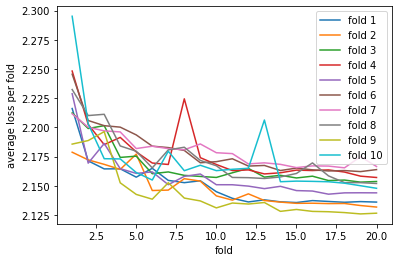

In [25]:
for i in range(0, len(loss_per_fold)):
    plt.plot([1+j for j in range(len(loss_per_fold[i]))],loss_per_fold[i], label = "fold "+str(i+1))
plt.xlabel("fold")
plt.ylabel("average loss per fold")
plt.legend()
plt.show()

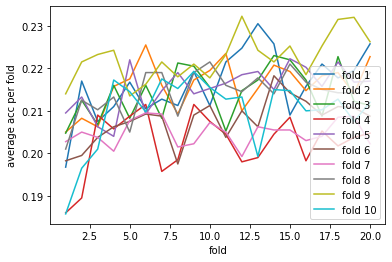

In [26]:
for i in range(0, len(acc_per_fold)):
    plt.plot([1+j for j in range(len(acc_per_fold[i]))],acc_per_fold[i], label = "fold "+str(i+1))
plt.xlabel("fold")
plt.ylabel("average acc per fold")
plt.legend()
plt.show()